# Linear Regression

## Modèle explicatif

On a observé deux ensembles de var X et Y sur n individus tel que $y = f(x) + \epsilon$

On suppose que $f$ est une fonction lineaire égale à: $f: x \mapsto ax + b$

### Différences avec l'ACP

Dans une ACP, les variables n'ont pas de relation entre elles.
Ici, y dépend de x.

### Critère des moindres carrées

Le résidu ($e_i = y_i - \hat{y}_i$) correspond à ce qui n'est pas expliqué par le modèle. On cherche à le minimiser.

On va chercher à a et b en minimisant le carré des résidus, c'est-à-dire:

$
\min \sum_i e^2_i = \min \sum_i (y_i - \hat{y}_i)^2
$

La solution optimale donne:

$
b = \frac {\sum (x_i - \overline{x})(y_i - \overline{y})}{\sum (x_i - \overline{x})^2}
b = \frac {cov(x,y)}{var(x)}
$

$
a = \overline{y} - b \overline{x}
$

In [1]:
# Iris dataset
!ls iris.data || wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

iris.data


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn import linear_model
from scipy.stats import norm
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv("iris.data", header=None, names=["sepal length", "sepal width", "petal length", "petal width", "class"])
df = df[df["class"] == "Iris-setosa"]
df.describe()

,sepal length,sepal width,petal length,petal width
count,50.00000,50.000000,50.000000,50.00000
mean,5.00600,3.418000,1.464000,0.24400
std,0.35249,0.381024,0.173511,0.10721
min,4.30000,2.300000,1.000000,0.10000
25%,4.80000,3.125000,1.400000,0.20000
50%,5.00000,3.400000,1.500000,0.20000
75%,5.20000,3.675000,1.575000,0.30000
max,5.80000,4.400000,1.900000,0.60000


Text(0, 0.5, 'sepal width')

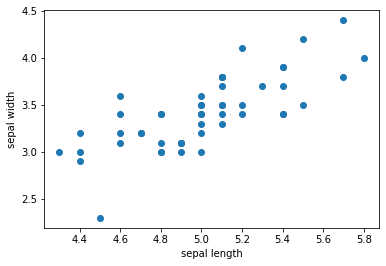

In [4]:
X = df["sepal length"]
y = df["sepal width"]
plt.scatter(X, y)
plt.xlabel("sepal length")
plt.ylabel("sepal width")

In [5]:
X_ = np.average(X)
y_ = np.average(y)
cov_Xy = np.sum((X - X_) * (y - y_))
var_x = np.sum((X - X_) ** 2)
a = cov_Xy / var_x
b = y_ - a * X_

reg = linear_model.LinearRegression()
reg.fit(X.to_numpy().reshape(1, -1).T, y)

res = sm.OLS(y, sm.add_constant(X, prepend=False)).fit()

pd.DataFrame([
    ["manually", a, b],
    ["sk-learn", reg.coef_[0], reg.intercept_],
    ["statsmodels", res.params[0], res.params[1]]],
    columns=["Method", "Coeff", "Intercept"])

,Method,Coeff,Intercept
0,manually,0.807234,-0.623012
1,sk-learn,0.807234,-0.623012
2,statsmodels,0.807234,-0.623012


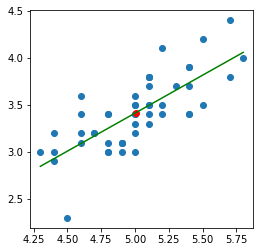

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
ax.plot(X_test, y_test, color="green")
ax.scatter(X_, y_, color="red")

### Propriétés

 - La droite passe par ($\overline{x}$, $\overline{y}$)
 - $\overline{y} = \hat{\overline{y}}$ (moyenne des y = moyenne des y prédits)
 - $\sum e_i = 0$
 - $\sum e_i x_i = 0$
 
### Qualité de l'ajustement linéaire

$
\underbrace{\sum (y_i - \overline{y})^2}_{\text{Somme des carrés totaux}} = \underbrace{\sum (y_i - \hat{y}_i)^2}_{\text{Somme des carrés des résidus (SCR)/information non expliquée}} + \underbrace{\sum (\hat{y}_i - \overline{y})^2}_{\text{Somme des carrés (SCE)/information expliquée par le modèle, par la droite}}
$

### Coefficient de détermination

$
R^2 = \frac{SCE}{SCT} = \frac {\sum (\hat{y}_i)^2 - \overline{y})^2}{\sum (y_i - \overline{y})^2} = b^2 \frac{s^2_x}{s^2_y} = (cor(x, y)) ^2
$

R² mesure l'ajustement de la droite aux données. R² explique la part de variation de y expliquée par la variation de x

## Etude des points influents et des résidus
### Contribution de chaque observation

**Levier** : Contribution d'un point à la construction de la droite
$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum (x_j - \overline{x})^2}
$

$h_i$ important is $\gt \frac {4}{n}$. Le levier indique une _potentielle_ influence par rapport à la pente. Pas d'influence => si on retire le point, elle n'impacte pas la droite

Un point abberant (éloigné de la droite) mais pas influent (proche de la moyenne) aura un levier faible => influence sur la distance de Cook faible = levier faible * résidu important

 - Influence en général: **Distance de Cook** pour l'observation i = $D_i = \frac {\hat{y_j} - \hat{y}_{(-i)j}} {2 \hat{\sigma}^2} = \underbrace {\frac{(e_i)^2}{\hat{\sigma}^2}}_{\text{résidu studentisé, influence / y}} \underbrace {\frac {h_i} {(1-h_i)^2}}_{\text{fonction du levier, influence / x}}$
 - Influence variabilité: **Cov Ratio**. Grand si |CovRatio - 1| >3 (P+1)/2
 - Influence prédiction: **DFFITS**. Grand si > 2 * sqrt(P+1) / n
 - Influence pente: **DFBETAS_x**. Grand si |DFBETAS| > 2 / sqrt(n)
 - Influence ordonnée à l'origine: **DFBETAS_intercept** 

/home/yvan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


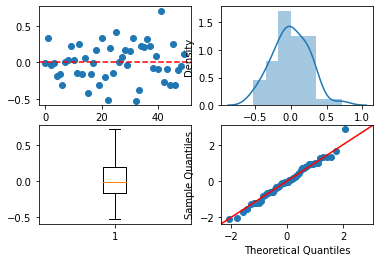

In [7]:
ŷ = a * X + b
residuals = (ŷ - y)
fig, ax = plt.subplots(2, 2)
ax[0, 0].scatter(range(len(residuals)), residuals)
ax[0, 0].axhline(y = 0, color = 'r', linestyle = 'dashed')

ax[1, 0].boxplot(residuals)

_ = sns.distplot(residuals, ax=ax[0, 1])

_ = sm.qqplot(residuals, stats.t, fit=True, line="45", ax=ax[1, 1])

Exemples de résidus ne respectant pas les hypothèses

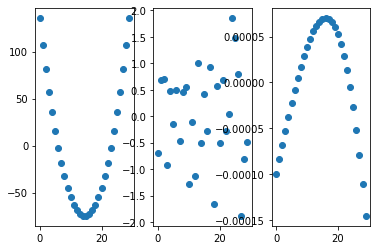

In [8]:
fig, ax = plt.subplots(1, 3)
eX = np.array(range(30))
e = [
    ["Relation non-linéaire entre x & y, envisager un modèle en x²", eX**2],
    ["Hétéroscédasticité. Le résidu augmente en fonction de x. Envisager de régresser log Y en x", eX+np.array([np.random.normal(loc=10*x, scale=1) for x in eX])],
    ["Autocorrelation, nécessite l'utilisation de séries chronologiques", np.sin(eX/200)]
]

for i, values in enumerate(e):
    text, ey = values
    res_e = sm.OLS(ey, sm.add_constant(eX, prepend=False)).fit()
    ax[i].scatter(eX, res_e.resid)

In [9]:
infl = res.get_influence()
iris_desc = pd.DataFrame(zip(
    infl.resid_std,
    infl.resid_studentized,
    infl.cooks_distance[0],
    infl.hat_matrix_diag,
    infl.cov_ratio,
    infl.dffits[0],
    infl.dfbetas[:, 0],
    infl.dfbetas[:, 1]), columns=[
    "StdDev Residual",
    "Student Residual",
    "Cook distance",
    "Hat Diag H",
    "Cov Ratio",
    "Dffits",
    "Dfbetas Coef",
    "Dfbetas Intercept",
])
iris_desc.head()

,StdDev Residual,Student Residual,Cook distance,Hat Diag H,Cov Ratio,Dffits,Dfbetas Coef,Dfbetas Intercept
0,0.253273,0.024164,0.000006,0.021451,1.065844,0.003540,0.000921,-0.000681
1,0.253222,-1.312812,0.019246,0.021846,0.991102,-0.197719,0.057468,-0.070485
2,0.251464,0.115378,0.000244,0.035380,1.080661,0.021868,-0.014418,0.015527
3,0.249935,0.038958,0.000037,0.047075,1.094461,0.008568,-0.006498,0.006871
4,0.253460,0.737171,0.005547,0.020006,1.040336,0.104818,-0.001802,0.009085


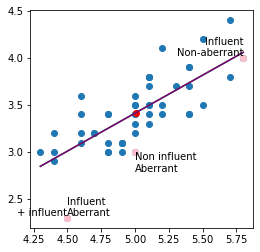

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
y_sm = res.params[0] * X_test + res.params[1]
ax.plot(X_test, y_test, color="green")
ax.plot(X_test, y_sm, color="purple")
ax.scatter(X_, y_, color="red")

points = [
    (41, 'Influent\nAberrant', 'left', 'bottom'),
    (14, 'Influent\nNon-aberrant', 'right', 'bottom'),
    (25, 'Non influent\nAberrant', 'left', 'top'),
    # index_point == 32
    (np.argmax(iris_desc["Cook distance"]), '+ influent', 'right', 'bottom'),
]

for index_point, text, ha, va in points:
    xp, yp = X[index_point], y[index_point]
    ax.scatter(xp, yp, color="pink")
    ax.text(xp, yp, text, ha=ha, va=va)

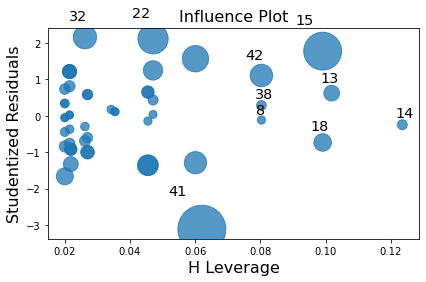

In [11]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

#### Reference

 - https://online.stat.psu.edu/stat462/node/173/
 - https://blogs.sas.com/content/iml/2019/06/19/influence-regression-dffits-cooksd.html
 - https://www.kaggle.com/code/kmaingleung/use-cooks-disatnce-dffits-for-outlier-detection


## Aspects inférentiels

### Modèle de regression simple

Soit ($X_i$, $y_i$), un **échantillon** de n individus issues de la population décrite par:
$
y_i = \underbrace{Y / x_i}_{\text{Loi Y conditionné à x_i (connu)}} = \alpha x_i + \beta + \epsilon_i
$

α et β sont des constantes inconnues.

#### Hypothèses

 * $E(epsilon_i)=0$ : évite un biais systématique
 * $V(epsilon_i)=\sigma^2$ : hypothèse d'homoscécadicité
 * $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$: hypothèse de normalité des erreurs => $y_i \sim \mathcal{N}(\alpha x_i + \beta, \sigma^2)$ 
 * $\epsilon_i$ identiques et indépendamment distribués (iid) <=> $\forall i \ne j, cov(\epsilon_i, \epsilon_j) = 0$
 
#### Estimateurs et loi des estimateurs

On va construire deux estimateurs A et B à partir de l'échantillon. La solutions du système des équations normales a et b donne les estimateurs des moindres carrés des paramètres α et β

Les résidus $\epsilon_i$ suivent une loi normale $\mathcal{N}(0, \sigma^2)$. Les estimateurs A et B des valeurs α et β suivent des lois normales.

$
A \sim \mathcal{N}(a, \frac{\sigma^2}{\sum (x_i - \overline{x})^2}) \\
B \sim \mathcal{N}(b, \sigma^2 \left [ \frac{1}{n} + \frac{\overline{x}}{\sum (x_i - \overline{x})^2} \right ])
$

Mais, $\sigma$, la variance des résidus, n'est pas **connu**. Il faut donc l'estimer! L'estimateur sans biais de la variance des erreurs  $\sigma^2$ est: $S_{n-2}^2 = \frac{1}{n-2} \sum (\hat{y}_i - y_i)^2$

$\frac{A - \alpha}{S_{A}}$ et $\frac{B - \beta}{S_{B}}$ suivent des lois de Student avec n-2 degrés de liberté ($T_{n-2}$) 

Avec:
$ 
S_A = S_{n-2} \frac{1}{\sqrt{\sum (x_i - \overline{x})^2}}
\ et\ 
S_B = S_{n-2} \sqrt{\frac{1}{n} + \frac{\overline{x}^2}{\sum (x_i - \overline{x})^2}}
$

In [12]:
from math import sqrt
n = len(residuals)
𝜎_squared = sqrt(sum(residuals**2) / (n - 2))
X_ = np.average(X)
S_A = 𝜎_squared / sqrt((sum((X - X_) ** 2)))
S_B = 𝜎_squared * sqrt((1/n) + (X_**2)/(sum((X - X_) ** 2)))
f"Estimation du coefficient et de l'ordonnée à l'origine = {((a, S_A), (b, S_B))}"

"Estimation du coefficient et de l'ordonnée à l'origine = ((0.807233665122696, 0.10376564391116416), (-0.623011727604216, 0.5207112617925006))"

### Intervalle de confiance

$S_A = S_{n-2} \frac{1}{\sqrt{\sum (x_i - \overline{x})^2}}$ suit la loi de Student à n-2 degrés de liberté. On peut fournir un encadrement de la moyenne avec une confiance de $\gamma$ = 5%

$
Pr[t_{n-2;\gamma/2} \le \frac{A - \alpha}{𝜎_A} \le t_{n-2;1 - \gamma/2}] = 1 - \gamma
$

In [13]:
t = 2
(a - t * S_A, a+ t * S_A)

(0.5997023773003677, 1.0147649529450242)

###  Tests des hypothèses

 - **Tests des paramètres**: H0 = {la pente de la droite vaut zéro} contre H1 = {la pente de la droite est différente de zéro} (respectivement l'ordonnée à l'origine). Statistique de test: A/S_A ~ T_n-2.
 
 - **Test de la signification du modèle** (test si tous les coeffcients sont supposés nuls, sauf la constante) . Quand cette valeur est suffisamment grande, cela signifie que la variabilité expliquée est importante par rapport à la variabilité des résidus (rejet de H0). 
 
H0 = {$y_i = \beta + \epsilon_i$} vs H1 = {$y_i = \beta + \alpha x_i + \epsilon_i$} 

$SCE \sim \chi^2_1$ et $SCR \sim \chi^2_{n-2}$.
La Loi de Fisher étant défini comme le rapport de deux lois du χ2.

Statistique de test: loi de Fisher
$
F = \frac{SCE}{SCR/(n-2)} \sim F_{1, n-2}
$

H0 est rejeté si $Pr[F_{1, n-2} > F_obs) < \gamma$

 - **Statistique de Durbin-Watson**: doit être proche de 2 si l'hypothèse H0 "non corrélation des résidus" est vraie
 
$D = \frac{\sum (e_{i+1} - e_i)^2}{\sum e_i^2}$

Autres: Test de Shapiro Wilks, de Kolmogorov-Smirnov

 - Le critère d’information d’Akaike (AIC) est défini par : AIC = −2 log eL + 2k où eL est la vraisemblance maximisée et k le nombre de paramètres dans le modèle. L’AIC représente donc un compromis entre le biais, diminuant avec le nombre de paramètres, et la parcimonie, volonté de décrire les données avec le plus petit nombre de paramètres possibles. Le meilleur modèle est celui possédant l’AIC le plus faible.

In [14]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sepal width   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     60.52
Date:                Sat, 24 Dec 2022   Prob (F-statistic):           4.75e-10
Time:                        13:33:53   Log-Likelihood:                -1.8042
No. Observations:                  50   AIC:                             7.608
Df Residuals:                      48   BIC:                             11.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sepal length     0.8072      0.104      7.779      0.000       0.599       1.016
const           -0.6230      0.521     -1.196      0.237      -1.670       0.424
==============================================================================
Omnibus:                        0.350   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.120
Skew:                          -0.120   Prob(JB):                        0.942
Kurtosis:                       3.018   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""